# lassoCV

This notebook demonstrates how to conduct Lasso with stratified K fold cross validation
on the Calling Cards data.  

## Pulling the data

The calling cards data should now strictly be taken from data source 'brent_nf_cc'. All
of the Mitra data has been reprocessed through the nf-core/callingcards:1.0.0 pipeline.  

Where there are multiple replicates, they have been aggregated. The `deduplicate`
parameter to `PromoterSetSigAPI()` selects aggregated data where it exists. Where
there is a single passing replicate, that replicate is used.

## Setup

As usual, import the `yeastdnnexplorer` interface functions

In [1]:
# configure the logger to print to console
import logging

import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV

from yeastdnnexplorer.interface import PromoterSetSigAPI, ExpressionAPI, metric_arrays, rank_transforms
from yeastdnnexplorer.ml_models.lasso_modeling import (
    generate_modeling_data,
    stratification_classification,
    stratified_cv_modeling,
    bootstrap_stratified_cv_modeling,
    examine_bootstrap_coefficients)


logging.basicConfig(level=logging.INFO)

pss_api = PromoterSetSigAPI()
expression_api = ExpressionAPI()

## Pull the deduplicated calling cards data

This will pull all of the currently usable data. In the future, we will remove 
"unreviewed". This will take a minute or two as it will need to fetch all of the
underlying data

In [2]:
pss_api.push_params(
    {
        "source_name": "brent_nf_cc",
        "deduplicate": "true",
        "data_usable": ["unreviewed", "pass"],
    }
)

pss_res = await pss_api.read(retrieve_files=True)

## Pull the corresponding perturbation data

In this case, we are pulling the McIsaac data. In order to label blacklisted genes,
we'll need the shrunken data. For modelling, we will use the unshrunken data.

In [3]:
expression_api.push_params(
    {
        "regulator_symbol": ",".join(
            pss_res.get("metadata").regulator_symbol.unique().tolist()
        ),
        "source_name": "mcisaac_oe",
        "time": "15",
    }
)

expression_res_shrunken = await expression_api.read(retrieve_files=True)

# this will add the effect_colname parameter to the expression API
expression_api.push_params(
    {
        "effect_colname": "log2_ratio",
    }
)

expression_res_unshrunken = await expression_api.read(retrieve_files=True)

## Transform the data into a usable format for modelling

Note that there are new functions, `metric_arrays` and'
`negative_log_transform_by_pvalue_and_enrichment`. See the API section of this
documentation for more details.  

You will likely want to save the results of this cell so that you do not have to run
the DB or transformation steps in future sessions, unless of course you need or want
to update the your data.

### Extract the data into a more managable format using `metric_arrays()`

In [ ]:
X = metric_arrays(
    pss_res,
    {"poisson_pval": np.min, "callingcards_enrichment": np.max},
)

Y = metric_arrays(
    expression_res_unshrunken,
    {"effect": np.max},
)

Y_shrunken = metric_arrays(
    expression_res_shrunken,
    {"effect": np.max},
)

### Create gene level filters

In this case, we wish to keep only the genes common to both the binding and expression,
and create a 'blacklist' of genes which are either always responsive, or always
unresponsive. The binding and response data will then be filtered such that only the
common set of genes, which are not in the blacklist, are retained for analysis

In [5]:
# define a set of common genes between X and y
common_genes = X["poisson_pval"].index.intersection(
    Y.get("effect", pd.DataFrame()).index
)

# binarize the Y.get("effect") DataFrame as True if the value is not 0
# We wish to exclude any genes that are always unresponsive OR always responsive
Y_binary = Y_shrunken.get("effect", pd.DataFrame()).eq(0)

always_unresponsive = Y_binary[~Y_binary.any(axis=1)].index
always_responsive = Y_binary[Y_binary.all(axis=1)].index

# combine always unresponsive and always responsive and intersect with common_genes
# to get the blacklisted genes

# define blacklisted genes as those records where the gene is either always responsive,
# or always unresponsive, in all experiments
blacklisted_genes = Y_binary[Y_binary.all(axis=1) | ~Y_binary.any(axis=1)].index.intersection(common_genes)

# Count summary
# NOTE: The blacklist is only over common genes. the always_unresponsive and always_responsive
# are over all genes in the response data
counts = pd.DataFrame.from_dict({
    "category": ["Always unresponsive (perturbation only)", "Always responsive (perturbation only)", "Blacklisted(only shared genes)"],
    "count": [len(always_unresponsive), len(always_responsive), len(blacklisted_genes)]
})

print(counts)

                                  category  count
0  Always unresponsive (perturbation only)      0
1    Always responsive (perturbation only)     92
2           Blacklisted(only shared genes)     90


### Use the common gene set and blacklist to filter the response and predictor data

In [6]:
# remove the blacklist genes from Y and retain only common genes
Y_filtered = Y.get("effect", pd.DataFrame()).loc[common_genes].drop(blacklisted_genes)

# remove the blacklisted_genes for X and retain only the common genes
X_filtered = {}
for key in X.keys():
    X_filtered[key] = X[key].loc[common_genes].drop(blacklisted_genes)

# Next, transform the X object into a predictors_df using the shifted negative log rank
# transformation. See `negative_log_transform_by_pvalue_and_enrichment` for more
# details
scores_list = [
    rank_transforms.negative_log_transform_by_pvalue_and_enrichment(
        X_filtered["poisson_pval"].loc[:, i],
        X_filtered["callingcards_enrichment"].loc[:, i],
    )
    for i in X_filtered["poisson_pval"].columns
]

# Convert the list of scores into a DataFrame
predictors_df = pd.DataFrame(scores_list).T

# Set the index and columns to match X_filtered["poisson_pval"]
predictors_df.index = X_filtered["poisson_pval"].index
predictors_df.columns = X_filtered["poisson_pval"].columns


# conduct a similar shifted negative log rank transformation on the Y values
Y_filtered_ranked = Y_filtered.rank(ascending=False, method="average")
Y_filtered_transformed = Y_filtered_ranked.apply(
    rank_transforms.shifted_negative_log_ranks, axis=0)

## Modeling per TF

This demonstrates the usage on a single TF. The TFs are the columns in both the 
response and predictor dataframes. To run this on all TFs, you would simply iterate
over the columns of the response DF. This can be done in parallel very easily on the
cluster.

In [ ]:
# NOTE: drop_intercept is TRUE -- the model matrix will be strictly the predictors,
# no constant term
cbf1_y, cbf1_X = generate_modeling_data("CBF1",
                                        Y_filtered_transformed, predictors_df,
                                        drop_intercept=True)

classes = stratification_classification(cbf1_X['CBF1'].squeeze(), cbf1_y.squeeze())

# NOTE: fit_intercept is set to `true`
lassoCV_estimator = LassoCV(
    fit_intercept=True,
    max_iter=10000,
    selection="random",
    random_state=42,
    n_jobs=4)

# Fit the model to the data in order to extract the alphas_ which are generated
# during the fitting process
lasso_model = stratified_cv_modeling(cbf1_y, cbf1_X, classes, lassoCV_estimator)

# set the alphas_ attribute of the lassoCV_estimator to the alphas_ attribute of the
# lasso_model fit on the whole data. This will allow the
# bootstrap_stratified_cv_modeling function to use the same set of lambdas
lassoCV_estimator.alphas_ = lasso_model.alphas_

# if testing this for the first time, setting n_bootstrap to 10 is recommended for
# speed
# NOTE: fit_intercept=True is passed to the internal Lasso model for bootstrap
# iterations, along with some other settings
bootstrap_lasso_output = bootstrap_stratified_cv_modeling(
    y=cbf1_y,
    X=cbf1_X,
    estimator=lassoCV_estimator,
    ci_percentile=99,
    n_bootstraps=1000,
    max_iter=10000,
    fit_intercept=True,
    selection="random",
    random_state=42)

## Visualize and extract significant coefficients

You can use `examine_boostrap_coefficients()` to generate a plot, and extract a list,
of coeffiecents whose user specified ci_interval exists beyond a specified threshold. 
For example, if `ci_interval = 95.0` and `threshold = 0`, then the coefficients that
are returned are those whose 95.0 confidence interval do not cross zero.  

In the example below, I set the ci_interval to 100.0 with a threshold of 0, which 
will return only coefficients where none of the bootstrap values cross 0.

Significant coefficients for 100.0, where intervals are entirely above or below ±0.0:
CBF1:DAT1: (-0.16940924467227142, -0.0017639790941411946)
CBF1:MET28: (0.02486046494795294, 0.22769735162287097)
CBF1:ABF1: (-0.1838813454555642, -0.01620972272568395)
CBF1:GAL4: (0.047538447355681204, 0.36526567966016715)
CBF1:MSN2: (0.013820123194068555, 0.2649142348597824)

The coefficient closest to 0 is: CBF1:DAT1: (-0.16940924467227142, -0.0017639790941411946)


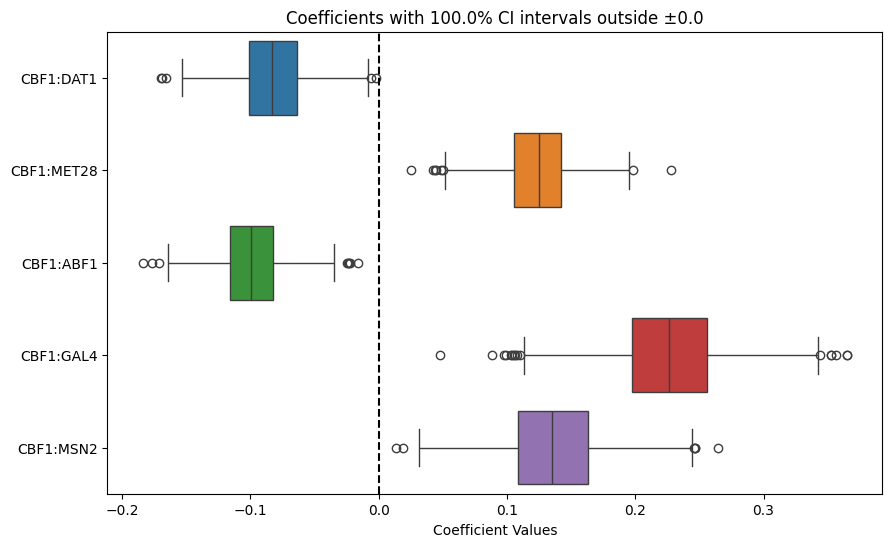

In [8]:
# Let's say we want to return coefficients where none of the bootstrapped coefficient
# estimates include 0. We can leave the `threshold` parameter as 0.0, and set `ci_level`
# to 100.00
sig_coef_plt, sig_coef_dict = examine_bootstrap_coefficients(
    bootstrap_lasso_output,
    ci_level=100.0)

# we can also find out which coefficient has a value closest to 0
min_key, min_bounds = min(sig_coef_dict.items(),
                          key=lambda item: min(abs(item[1][0]), abs(item[1][1])))

print(f"\nThe coefficient closest to 0 is: {min_key}: {min_bounds}")

## Using the cmd line utility

There is a command line utility called lasso_bootstrap that may be launched like this:

```bash
#!/bin/bash

python -m yeastdnnexplorer lasso_bootstrap \
    --response_file ../lasso_response_mcisaac15.csv \
    --predictors_file ../lasso_predictors_callingcards.csv \
    --perturbed_tf CBF1 \
    --n_bootstrap 1000 \
    --log-level ERROR
```

The output will, by default, be in a directory in the `PWD` called
`lasso_bootstrap_output` with subdirectories named by `--perturbed_tf`. The output
of `bootstrap_lasso_output()` will be saved, along with a lassoCV model run on the
entire dataset as a joblib file.  

To examine the results using `examine_bootstrap_coefficients()`, you would load the
data like this:

```python
import json
import pandas as pd

from yeastdnnexplorer.ml_models.lasso_modeling import examine_bootstrap_coefficients


with open("lasso_bootstrap_output/CBF1/ci_dict.json", "r") as file:
    coef_dict = json.load(file)

coef_df = pd.read_csv("testing_lasso_cmd/lasso_bootstrap_output/CBF1/bootstrap_coef_df.csv")

alphas_list = pd.read_csv("lasso_bootstrap_output/CBF1/bootstrap_alphas.csv")['alpha'].tolist()

bootstrap_lasso_output = (coef_dict, coef_df, alphas_list)

sig_coef_plt, sig_coef_dict = examine_bootstrap_coefficients(
    bootstrap_lasso_output,
    ci_level=100.0)

```